In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Initial Data Preparation

In [34]:
df = pd.read_csv('bling.csv')

In [35]:
df_ex = df.copy()

In [36]:
df.head(2)

,bba_id,bba_balance,bba_updated_at
0,0007e8ab-9d21-43ca-86cc-b45c0293950a,0.0,2024-01-09 23:10:39.399853+00
1,0007e8ab-9d21-43ca-86cc-b45c0293950a,0.0,2024-01-10 23:09:19.924418+00


In [37]:
df.describe(include='all')

,bba_id,bba_balance,bba_updated_at
count,3139,3139.000000,3139
unique,100,NaN,3139
top,00f1255b-83c7-44f8-9254-21dc9c369e65,NaN,2024-01-09 23:10:39.399853+00
freq,173,NaN,1
mean,NaN,178.535081,NaN
std,NaN,337.704236,NaN
min,NaN,0.000000,NaN
25%,NaN,0.895000,NaN
50%,NaN,37.400000,NaN
75%,NaN,212.930000,NaN


In [38]:
df['bba_updated_at'] = pd.to_datetime(df['bba_updated_at'])  # Convert to datetime

In [39]:
# Extract date components from 'bba_updated_at'
df['year'] = df['bba_updated_at'].dt.year
df['month'] = df['bba_updated_at'].dt.month
df['day'] = df['bba_updated_at'].dt.day
df['day_of_week'] = df['bba_updated_at'].dt.day_name()  # For the day name (e.g., Monday)
df['week_of_year'] = df['bba_updated_at'].dt.isocalendar().week  # ISO week number
df['quarter'] = df['bba_updated_at'].dt.quarter
df['hour'] = df['bba_updated_at'].dt.hour
df['minute'] = df['bba_updated_at'].dt.minute
df['second'] = df['bba_updated_at'].dt.second
df['date'] = df['bba_updated_at'].dt.date


### Data Exploration

In [40]:

# Inspect the Data
print(df.info())  # Check data types and missing values
print(df.describe())  # Summary statistics for numeric columns


# Check for missing values
print(df.isnull().sum())

# Check for duplicates
print("Number of duplicate rows: ", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3139 entries, 0 to 3138
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   bba_id          3139 non-null   object             
 1   bba_balance     3139 non-null   float64            
 2   bba_updated_at  3139 non-null   datetime64[ns, UTC]
 3   year            3139 non-null   int32              
 4   month           3139 non-null   int32              
 5   day             3139 non-null   int32              
 6   day_of_week     3139 non-null   object             
 7   week_of_year    3139 non-null   UInt32             
 8   quarter         3139 non-null   int32              
 9   hour            3139 non-null   int32              
 10  minute          3139 non-null   int32              
 11  second          3139 non-null   int32              
 12  date            3139 non-null   object             
dtypes: UInt32(1), datetime64[ns, UTC]

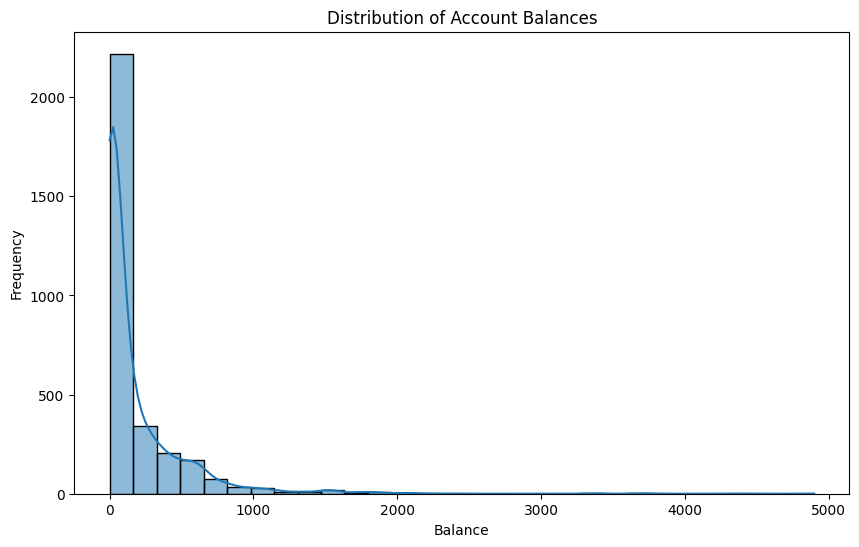

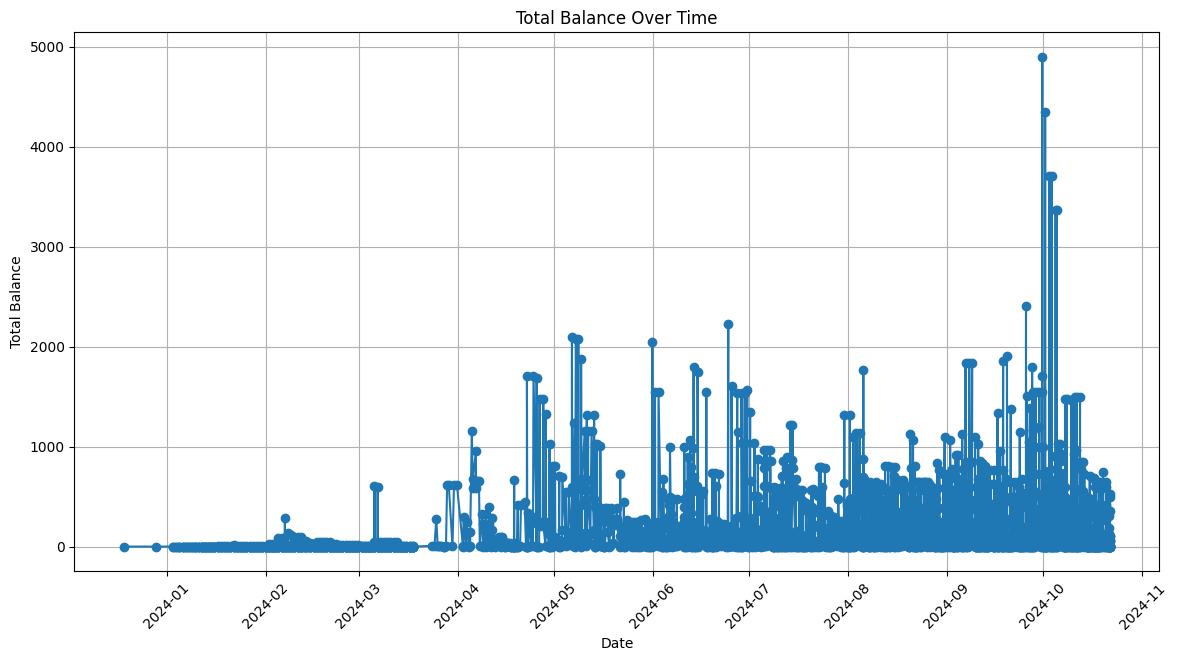

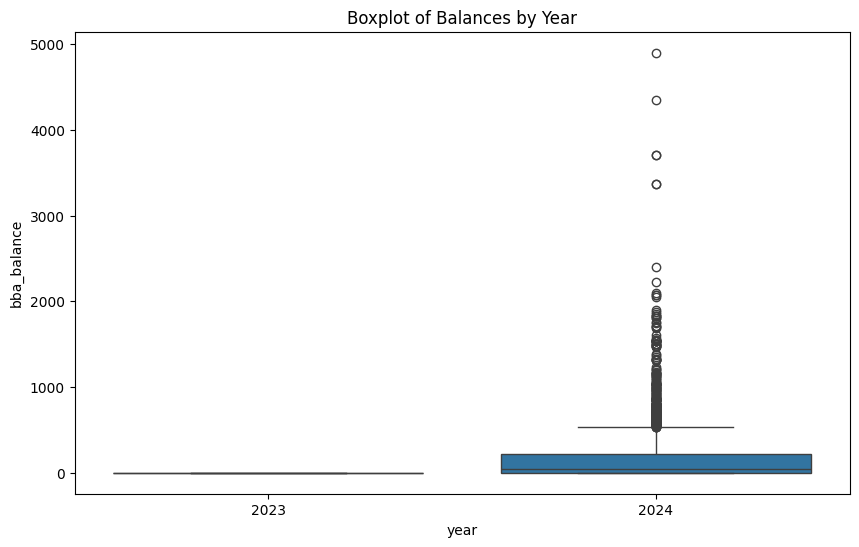

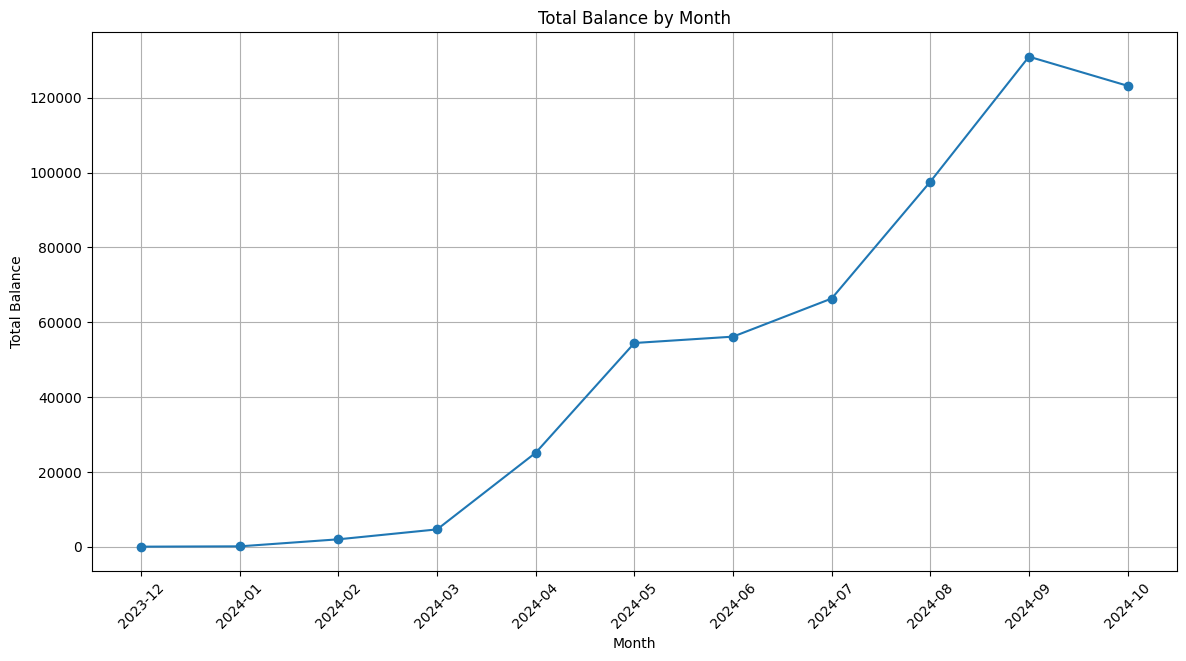

In [41]:
# Distribution of balances
plt.figure(figsize=(10, 6))
sns.histplot(df['bba_balance'], bins=30, kde=True)
plt.title('Distribution of Account Balances')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.show()

# Balance distribution over time (trend)
plt.figure(figsize=(14, 7))
df_grouped = df.groupby('bba_updated_at')['bba_balance'].sum().reset_index()
plt.plot(df_grouped['bba_updated_at'], df_grouped['bba_balance'], marker='o')
plt.title('Total Balance Over Time')
plt.xlabel('Date')
plt.ylabel('Total Balance')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Boxplot of balances to check for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='bba_balance', data=df)
plt.title('Boxplot of Balances by Year')
plt.show()


# Aggregating balances by month or week (time-based analysis)
df['month'] = df['bba_updated_at'].dt.to_period('M')  # Create month column
monthly_balance = df.groupby('month')['bba_balance'].sum().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(monthly_balance['month'].astype(str), monthly_balance['bba_balance'], marker='o')
plt.title('Total Balance by Month')
plt.xlabel('Month')
plt.ylabel('Total Balance')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Reconstituting Data

In [42]:
import pandas as pd

# Step 1: Extract just the date part from 'bba_updated_at' and find max date as a fixed end date
df['date'] = df['bba_updated_at'].dt.date
max_date = df['date'].max()  # Global end date for all accounts

# Find the minimum date for each bba_id as its unique start date
account_min_dates = df.groupby('bba_id')['date'].min().reset_index(name='start_date')

# Step 2: Check distinct dates available for each account
# Group by 'bba_id' and count the number of distinct days for each account
account_date_counts = df.groupby('bba_id')['date'].nunique().reset_index(name='recorded_dates')

# Step 3: Calculate the expected dates per account and count missing dates
# Merge the distinct date counts with start dates
account_date_counts = account_date_counts.merge(account_min_dates, on='bba_id')

# Calculate expected dates for each bba_id based on its unique start date to the fixed end date
account_date_counts['expected_dates'] = account_date_counts.apply(
    lambda x: len(pd.date_range(start=x['start_date'], end=max_date)), axis=1
)
account_date_counts['missing_dates'] = account_date_counts['expected_dates'] - account_date_counts['recorded_dates']

# Step 4: Investigate which accounts are missing dates
missing_accounts = account_date_counts[account_date_counts['missing_dates'] > 0]

# Display accounts with missing balances
print(missing_accounts)
account_date_counts.head()


                                  bba_id  recorded_dates  start_date  \
0   0007e8ab-9d21-43ca-86cc-b45c0293950a             109  2024-01-09   
1   000b87fa-e2f2-4948-9151-f8530b7ed54d              30  2024-08-29   
2   000ca659-4a4a-4cde-8d8b-d9417d18468a               3  2024-04-22   
3   000ef77b-de37-4063-b798-a3f22b0065f7               3  2024-04-15   
4   00190c61-fcc2-46e8-adba-f09df0c39b0f               4  2024-10-10   
..                                   ...             ...         ...   
95  01d73479-2f79-49f5-9c73-5c212d52a9f2               2  2024-09-23   
96  01e283a9-fce2-45fa-9c40-111cf8a76a50              28  2024-04-22   
97  01eadbb8-fa05-4326-b959-1041f25c4f97             122  2023-12-28   
98  01eb0fe6-3dfb-481b-a8bb-fce23fd991ad              53  2024-04-18   
99  01ecb3fc-f45b-41b3-88c7-fc2160f21a71              19  2024-04-18   

    expected_dates  missing_dates  
0              288            179  
1               55             25  
2              184         

,bba_id,recorded_dates,start_date,expected_dates,missing_dates
0,0007e8ab-9d21-43ca-86cc-b45c0293950a,109,2024-01-09,288,179
1,000b87fa-e2f2-4948-9151-f8530b7ed54d,30,2024-08-29,55,25
2,000ca659-4a4a-4cde-8d8b-d9417d18468a,3,2024-04-22,184,181
3,000ef77b-de37-4063-b798-a3f22b0065f7,3,2024-04-15,191,188
4,00190c61-fcc2-46e8-adba-f09df0c39b0f,4,2024-10-10,13,9


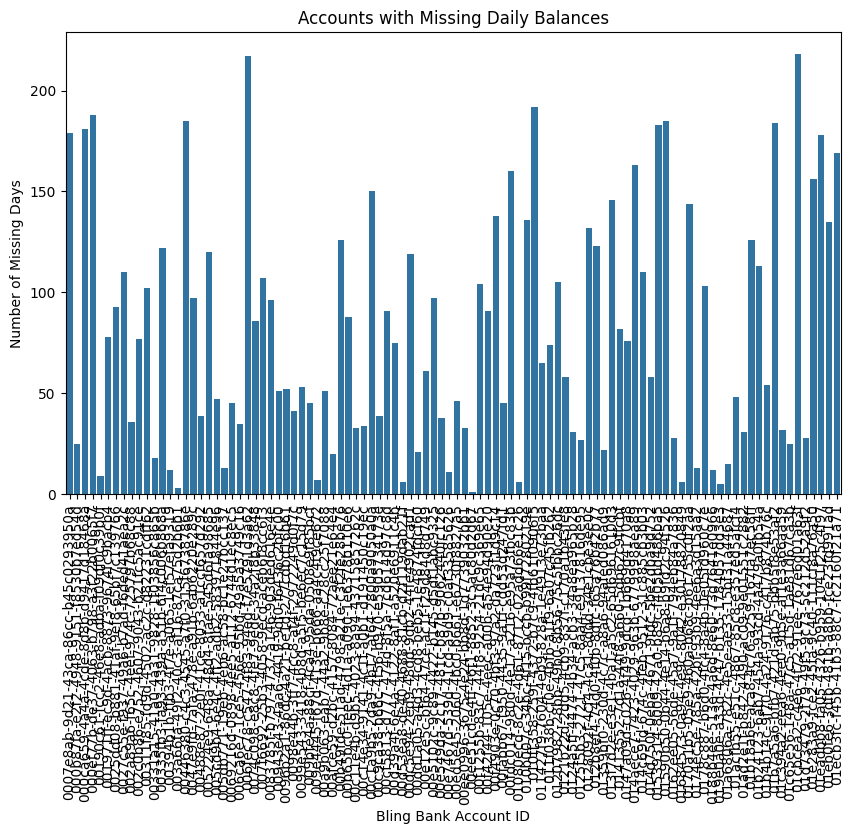

In [43]:
# Step 5: visualize accounts with missing balances
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='bba_id', y='missing_dates', data=missing_accounts)
plt.xticks(rotation=90)
plt.title('Accounts with Missing Daily Balances')
plt.ylabel('Number of Missing Days')
plt.xlabel('Bling Bank Account ID')
plt.show()


In [44]:
duplicates_df = df[df.duplicated(subset=['bba_id', 'date'], keep=False)]
print("Duplicates in df:")
print(duplicates_df.head())

Duplicates in df:
                                   bba_id  bba_balance  \
313  002c0b86-e752-4607-9043-b21fc5ac91ce       306.31   
314  002c0b86-e752-4607-9043-b21fc5ac91ce       292.91   
390  005224e9-648a-48d4-8fae-545d6fa98685       182.90   
391  005224e9-648a-48d4-8fae-545d6fa98685       182.90   
434  005224e9-648a-48d4-8fae-545d6fa98685        42.36   

                      bba_updated_at  year    month  day day_of_week  \
313 2024-10-17 06:49:03.930049+00:00  2024  2024-10   17    Thursday   
314 2024-10-17 17:17:33.655773+00:00  2024  2024-10   17    Thursday   
390 2024-08-08 15:04:02.830553+00:00  2024  2024-08    8    Thursday   
391 2024-08-08 20:22:38.423248+00:00  2024  2024-08    8    Thursday   
434 2024-10-17 05:47:00.841877+00:00  2024  2024-10   17    Thursday   

     week_of_year  quarter  hour  minute  second        date  
313            42        4     6      49       3  2024-10-17  
314            42        4    17      17      33  2024-10-17  
390        

In [45]:
df.columns

Index(['bba_id', 'bba_balance', 'bba_updated_at', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'quarter', 'hour', 'minute', 'second',
       'date'],
      dtype='object')

In [46]:
# Sort by 'bba_id', 'date', and 'bba_updated_at' to keep the latest entry per day
df = df.sort_values(['bba_id', 'date', 'bba_updated_at'])

# Remove duplicates by keeping the last entry for each 'bba_id' and 'date' combination
df = df.drop_duplicates(subset=['bba_id', 'date', 'year', 'month', 'day'], keep='last').reset_index(drop=True)

# Display the result to confirm
print(df.head())

                                 bba_id  bba_balance  \
0  0007e8ab-9d21-43ca-86cc-b45c0293950a          0.0   
1  0007e8ab-9d21-43ca-86cc-b45c0293950a          0.0   
2  0007e8ab-9d21-43ca-86cc-b45c0293950a          0.0   
3  0007e8ab-9d21-43ca-86cc-b45c0293950a          0.0   
4  0007e8ab-9d21-43ca-86cc-b45c0293950a          0.0   

                    bba_updated_at  year    month  day day_of_week  \
0 2024-01-09 23:10:39.399853+00:00  2024  2024-01    9     Tuesday   
1 2024-01-10 23:09:19.924418+00:00  2024  2024-01   10   Wednesday   
2 2024-01-11 23:07:48.712142+00:00  2024  2024-01   11    Thursday   
3 2024-01-12 23:06:25.745332+00:00  2024  2024-01   12      Friday   
4 2024-01-13 23:09:04.659915+00:00  2024  2024-01   13    Saturday   

   week_of_year  quarter  hour  minute  second        date  
0             2        1    23      10      39  2024-01-09  
1             2        1    23       9      19  2024-01-10  
2             2        1    23       7      48  2024-01-11 

In [47]:
print("Row count in original df:", len(df_ex))

print("Row count in df after keeping latest balance:", len(df))

Row count in original df: 3139
Row count in df after keeping latest balance: 3109


In [48]:
# Step 6: Extract unique 'bba_id' values from the original DataFrame
bba_id_fill = df['bba_id'].unique()

min_date = df['bba_updated_at'].min().date()
max_date = df['bba_updated_at'].max().date()

# Generate the full date range for the entire period
full_date_range = pd.date_range(start=min_date, end=max_date)

print("Overall Date Range:")
print(f"Start Date: {min_date}")
print(f"End Date: {max_date}")

# Create a new DataFrame with each 'bba_id' and every date in 'full_date_range'
df_fill = pd.MultiIndex.from_product(
    [bba_id_fill, full_date_range], names=['bba_id', 'date']
).to_frame(index=False)

#  Add 'bba_balance_fill' column with NaN values
# df_fill['bba_balance_fill'] = pd.NA

# Inspect the resulting df_fill
print(df_fill.head())


Overall Date Range:
Start Date: 2023-12-18
End Date: 2024-10-22
                                 bba_id       date
0  0007e8ab-9d21-43ca-86cc-b45c0293950a 2023-12-18
1  0007e8ab-9d21-43ca-86cc-b45c0293950a 2023-12-19
2  0007e8ab-9d21-43ca-86cc-b45c0293950a 2023-12-20
3  0007e8ab-9d21-43ca-86cc-b45c0293950a 2023-12-21
4  0007e8ab-9d21-43ca-86cc-b45c0293950a 2023-12-22


In [49]:
# Calculate the count of unique rows for each `bba_id`
unique_counts = df_fill.groupby('bba_id').size()

# Filter and display `bba_id`s with counts <> than 310
unique_counts_above_310 = unique_counts[unique_counts != 310]
print(unique_counts_above_310)


Series([], dtype: int64)


In [50]:
df_fill.head(1)

,bba_id,date
0,0007e8ab-9d21-43ca-86cc-b45c0293950a,2023-12-18


In [51]:
duplicates_df_fill = df_fill[df_fill.duplicated(subset=['bba_id', 'date'], keep=False)]
print("Duplicates in df_fill:")
print(duplicates_df_fill)


Duplicates in df_fill:
Empty DataFrame
Columns: [bba_id, date]
Index: []


In [52]:
# Ensure the 'date' column in both DataFrames is of type datetime
df['date'] = pd.to_datetime(df['date'])
df_fill['date'] = pd.to_datetime(df_fill['date'])



# Now perform the left join between df_fill and df based on 'bba_id' and 'date'
df_merged = df_fill.merge(df[['bba_id', 'date', 'bba_balance']],
                          on=['bba_id', 'date'],
                          how='left')

# Rename the merged balance column to 'bba_balance_fill' to reflect it's the filled version
# df_merged = df_merged.rename(columns={'bba_balance': 'bba_balance_fill'})

# Duplicate the 'bba_balance_fill' column to create 'bba_balance_dup'
df_merged['bba_balance_fill'] = df_merged['bba_balance']


# Display the result to verify
print(df_merged.head())


                                 bba_id       date  bba_balance  \
0  0007e8ab-9d21-43ca-86cc-b45c0293950a 2023-12-18          NaN   
1  0007e8ab-9d21-43ca-86cc-b45c0293950a 2023-12-19          NaN   
2  0007e8ab-9d21-43ca-86cc-b45c0293950a 2023-12-20          NaN   
3  0007e8ab-9d21-43ca-86cc-b45c0293950a 2023-12-21          NaN   
4  0007e8ab-9d21-43ca-86cc-b45c0293950a 2023-12-22          NaN   

   bba_balance_fill  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  


In [53]:

# Calculate the count of unique rows for each `bba_id`
unique_counts = df_merged.groupby('bba_id').size()

# Print the counts
print(unique_counts)

# Filter and display `bba_id`s with counts <> than 310
unique_counts_above_310 = unique_counts[unique_counts != 310]
print(unique_counts_above_310)


bba_id
0007e8ab-9d21-43ca-86cc-b45c0293950a    310
000b87fa-e2f2-4948-9151-f8530b7ed54d    310
000ca659-4a4a-4cde-8d8b-d9417d18468a    310
000ef77b-de37-4063-b798-a3f22b0065f7    310
00190c61-fcc2-46e8-adba-f09df0c39b0f    310
                                       ... 
01d73479-2f79-49f5-9c73-5c212d52a9f2    310
01e283a9-fce2-45fa-9c40-111cf8a76a50    310
01eadbb8-fa05-4326-b959-1041f25c4f97    310
01eb0fe6-3dfb-481b-a8bb-fce23fd991ad    310
01ecb3fc-f45b-41b3-88c7-fc2160f21a71    310
Length: 100, dtype: int64
Series([], dtype: int64)


In [54]:
df_merged.columns

Index(['bba_id', 'date', 'bba_balance', 'bba_balance_fill'], dtype='object')

#### Filling the data Preparation

In [55]:
# Sort by `bba_id` and `date` to ensure forward fill works in chronological order
df_merged = df_merged.sort_values(['bba_id', 'date']).reset_index(drop=True)

# Forward-fill `bba_balance_fill` within each `bba_id` group
df_merged['bba_balance_fill'] = df_merged.groupby('bba_id')['bba_balance_fill'].ffill()

# # Backward-fill within each `bba_id` group to fill any remaining NaNs before the first recorded balance
# df_merged['bba_balance_fill'] = df_merged['bba_balance_fill'].fillna("not_registered")

# # Display the result to confirm
# print(df_merged.head())

# df_merged.drop(columns=['bba_balance_fill'], axis=1, inplace=True)


In [56]:
# Ensure the 'date' column is in datetime format
df_merged['date'] = pd.to_datetime(df_merged['date'])

# Extract date hierarchies and add them as new columns
df_merged['year'] = df_merged['date'].dt.year
df_merged['month'] = df_merged['date'].dt.month
df_merged['day'] = df_merged['date'].dt.day
df_merged['day_of_week'] = df_merged['date'].dt.dayofweek  # Monday=0, Sunday=6
df_merged['week_of_year'] = df_merged['date'].dt.isocalendar().week
df_merged['quarter'] = df_merged['date'].dt.quarter

# Display the updated DataFrame to confirm
print(df_merged.head())


                                 bba_id       date  bba_balance  \
0  0007e8ab-9d21-43ca-86cc-b45c0293950a 2023-12-18          NaN   
1  0007e8ab-9d21-43ca-86cc-b45c0293950a 2023-12-19          NaN   
2  0007e8ab-9d21-43ca-86cc-b45c0293950a 2023-12-20          NaN   
3  0007e8ab-9d21-43ca-86cc-b45c0293950a 2023-12-21          NaN   
4  0007e8ab-9d21-43ca-86cc-b45c0293950a 2023-12-22          NaN   

   bba_balance_fill  year  month  day  day_of_week  week_of_year  quarter  
0               NaN  2023     12   18            0            51        4  
1               NaN  2023     12   19            1            51        4  
2               NaN  2023     12   20            2            51        4  
3               NaN  2023     12   21            3            51        4  
4               NaN  2023     12   22            4            51        4  


### Validating Reconstitution

In [57]:
# Basic summary statistics by account
summary_stats = df_merged.groupby('bba_id')['bba_balance_fill'].describe()
print(summary_stats)

                                      count        mean         std   min  \
bba_id                                                                      
0007e8ab-9d21-43ca-86cc-b45c0293950a  288.0   12.047951   30.357487  0.00   
000b87fa-e2f2-4948-9151-f8530b7ed54d   55.0  171.046727  193.085828  4.65   
000ca659-4a4a-4cde-8d8b-d9417d18468a  184.0    0.195652    0.595780  0.00   
000ef77b-de37-4063-b798-a3f22b0065f7  191.0    0.130890    1.808937  0.00   
00190c61-fcc2-46e8-adba-f09df0c39b0f   13.0    0.353846    0.841740  0.00   
...                                     ...         ...         ...   ...   
01d73479-2f79-49f5-9c73-5c212d52a9f2   30.0    0.000000    0.000000  0.00   
01e283a9-fce2-45fa-9c40-111cf8a76a50  184.0    3.193913    9.046381  0.00   
01eadbb8-fa05-4326-b959-1041f25c4f97  300.0   23.799700  106.927389  0.00   
01eb0fe6-3dfb-481b-a8bb-fce23fd991ad  188.0   13.255479   30.689941  0.00   
01ecb3fc-f45b-41b3-88c7-fc2160f21a71  188.0   14.509894   74.840692  0.00   

In [58]:
# Check if any NaNs remain after forward and backward fill
missing_check = df_merged['bba_balance'].isna().sum()
print(f"Remaining missing values: {missing_check}")


Remaining missing values: 27891


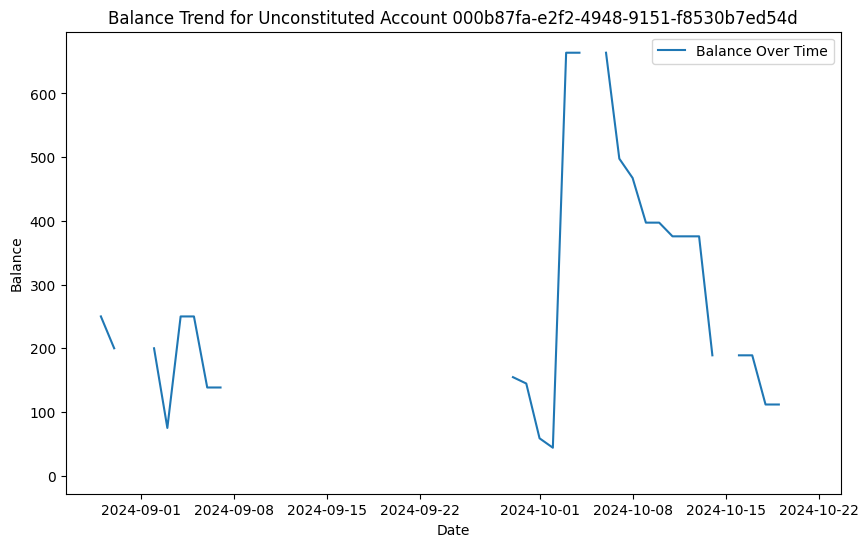

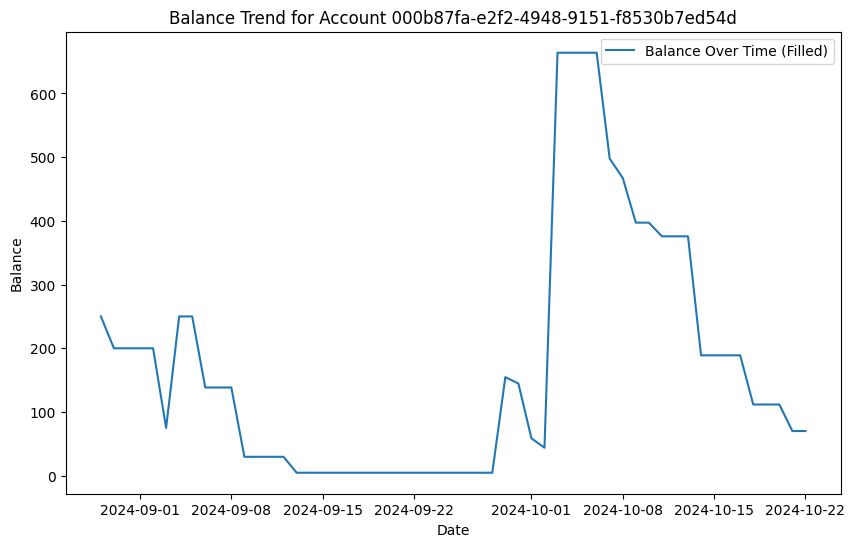

In [59]:
import matplotlib.pyplot as plt

# Replace 'ACCOUNT_ID' with the specific account ID you want to visualize
account_id = '000b87fa-e2f2-4948-9151-f8530b7ed54d'
sample_account = df_merged[df_merged['bba_id'] == account_id]

# Plot the time series for the selected account
plt.figure(figsize=(10, 6))
plt.plot(sample_account['date'], sample_account['bba_balance'], label='Balance Over Time')
plt.title(f"Balance Trend for Unconstituted Account {account_id}")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.legend()
plt.show()



# Filter out rows where `bba_balance_fill` is "not_registered"
sample_account_filtered = sample_account[sample_account['bba_balance_fill'] != "not_registered"]

# Plot `bba_balance_fill`, excluding "not_registered" entries
plt.figure(figsize=(10, 6))
plt.plot(sample_account_filtered['date'], sample_account_filtered['bba_balance_fill'], label='Balance Over Time (Filled)')
plt.title(f"Balance Trend for Account {account_id}")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.legend()
plt.show()


In [60]:
# Create a datekey column in YYYYMMDD format
df_merged['datekey'] = df_merged['date'].apply(lambda x: int(x.strftime('%Y%m%d')))

In [61]:
df_merged.to_csv('bba_daily_reconstituted.csv', index=False)

In [62]:
import openpyxl

df_merged.to_excel('bba_daily_reconstituted.xlsx', index=False, engine='openpyxl')